# Mask R-CNN
Configurations and data loading code for RSNA Pneumonia dataset.

Copyright (c) 2020 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla

------------------------------------------------------------

Usage: import the module (see Jupyter notebooks for examples), or run from
       the command line as such:

    # Train a new model starting from pre-trained COCO weights
    python3 rsna.py train --dataset=/path/to/rsna/ --model=coco

    # Train a new model starting from ImageNet weights. Also auto download COCO dataset
    python3 rsna.py train --dataset=/path/to/rsna/ --model=imagenet --download=True

    # Continue training a model that you had trained earlier
    python3 rsna.py train --dataset=/path/to/rsna/ --model=/path/to/weights.h5

    # Continue training the last model you trained
    python3 rsna.py train --dataset=/path/to/rsna/ --model=last

    # Run COCO evaluation on the last model you trained
    python3 rsna.py evaluate --dataset=/path/to/rsna/ --model=last

In [1]:
import os
import sys
import time
import numpy as np
import skimage
import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pydicom as dicom
import random
import imgaug as ia # https://github.com/aleju/imgaug (pip3 install imgaug)
import imgaug.augmenters as iaa
import imageio
import math
import tensorflow as tf 

from numpy import mean
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from sklearn.model_selection import train_test_split
from math import pow
from mrcnn import visualize
from mrcnn.model import log
from PIL import Image
from datetime import datetime

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Import custom utils
from rsna_utils import RsnaUtils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# TODO: update the path
RSNA_WEIGHTS_PATH = os.path.join(ROOT_DIR, "logs/mask_rcnn_rsna.h5")

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

print("Executed")

Using TensorFlow backend.


Executed


## Configurations

In [2]:
# TODO: update the value
# CUSTOM_LR = 

class RsnaConfig(Config):
    """Configuration for training on RSNA Pneumonia.
    Derives from the base Config class and overrides values specific
    to the RSNA dataset.
    """
    # Give the configuration a recognizable name
    NAME = "rsna"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2
    
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Uncomment to train on 3 GPUs (default is 1)
    GPU_COUNT = 3

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + 1 class (pneumonia)
    
    # Learning rate and momentum
    LEARNING_RATE = 0.0001
    LEARNING_MOMENTUM = 0.9

print("Executed")

Executed


In [ ]:
## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

print("Executed")

Executed


## Create an instance of the RsnaConfig class

In [4]:
config = RsnaConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     6
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      3
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

## Dataset

In [5]:
class RsnaDataset(utils.Dataset):
    def train_val_dataset(self, df1, df2, df, images_dir):
        """
        Load the train/val dataset.
        df1: Target == 0 dataframe
        df2: Target == 1 dataframe
        """
        for patientId in df1.patientId.unique():
            imageId = patientId
            imgPath = os.path.join(images_dir, patientId) + ".png"
            h, w = 1024, 1024
            ann = list()
            self.add_image("rsna", image_id = imageId, path = imgPath, annotation = ann, height=h, width=w)
        for patientId in df2.patientId.unique():
            imageId = patientId
            imgPath = os.path.join(images_dir, patientId) + ".png"
            h, w = 1024, 1024
            ann = df[df.patientId.str.match(patientId)]
            self.add_image("rsna", image_id = imageId, path = imgPath, annotation = ann, height=h, width=w)
        
    def load_rsna(self, dataset_dir, subset, df1, df2):
        """Load a subset of the RSNA dataset.
        dataset_dir: The root directory of the RSNA dataset.
        subset: What to load (train or val)
        """
        # Train or validation dataset?
        assert subset in ["train", "val", "test"]
        
        rsna_utils = RsnaUtils(dataset_dir)

        # Load annotations and sort by Target column
        df = rsna_utils.prepare_label()
        
        # Images directory
        images_dir = os.path.join(dataset_dir, "train")
                                      
        # Add class
        self.add_class("rsna", 1, "pneumonia")
        
        # Add images
        self.train_val_dataset(df1, df2, df, images_dir)
        
    def extract_boxes(self, x, y, w, h):
        boxes = list()
        x = int(x)
        y = int(y)
        w = int(w)
        h = int(h)
        boxes.extend([x, y, w, h])
        return boxes

    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # Get image info
        info = self.image_info[image_id]
        
        # Get image annotation
        ann = info['annotation']
        
        # For Target == 0
        if len(ann) == 0:
            boxes = list()
        # For Target == 1 
        else:
            boxes = [self.extract_boxes(x, y, w, h) for x, y, w, h in 
                     zip(ann['x'], ann['y'], ann['width'], ann['height'])]
        # Create mask
        mask = np.zeros([info['height'], info['width'], len(boxes)], dtype=np.uint8)
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[1] + box[3]
            col_s, col_e = box[0], box[0] + box[2]
            mask[row_s:row_e, col_s:col_e, i] = 1
            
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info['source'] == "rsna":
            return info['path']
        else:
            return "You tell me"
        
    def image_info_alt(self, image_id):
        """
        Return the image info
        """
        return self.image_info[image_id]

print("Executed")

Executed


## Load the datasets (Train)

In [6]:
dataset_dir = os.path.join(ROOT_DIR, "datasets/rsna")
rsna_utils = RsnaUtils(dataset_dir)
print("Dataset dir:", dataset_dir)

X_train, X_val, Y_train, Y_val = rsna_utils.prepare_rsna()

print("Executed")

Dataset dir: /storage/phongvt/GitHub/Mask_RCNN/datasets/rsna
Number of person with pneumonia: 6012
Others: 6000
Executed


In [11]:
dataset_train = RsnaDataset()
dataset_train.load_rsna(dataset_dir, "train", X_train, Y_train)
dataset_train.prepare()
print("Train:", len(dataset_train.image_ids))

Train: 8408


## Load the datasets (Val/Test)

In [7]:
# Random seed
random.seed(datetime.now())

X_val, X_test = train_test_split(X_val, test_size=0.5, random_state=random.randint(0, 69))
Y_val, Y_test = train_test_split(Y_val, test_size=0.5, random_state=random.randint(0, 69))

dataset_val = RsnaDataset()
dataset_val.load_rsna(dataset_dir, "val", X_val, Y_val)
dataset_val.prepare()
print("Val:", len(dataset_val.image_ids))

dataset_test = RsnaDataset()
dataset_test.load_rsna(dataset_dir, "test", X_test, Y_test)
dataset_test.prepare()
print("Test:", len(dataset_test.image_ids))

print("Executed")

Val: 1802
Test: 1802
Executed


In [8]:
print("Negative (train):", X_train.shape[0])
print("Positive (train):", Y_train.shape[0])
print("Negative (val):", X_val.shape[0])
print("Positive (val):", Y_val.shape[0])
print("Negative (test):", X_test.shape[0])
print("Positive (test):", Y_test.shape[0])

Negative (train): 4200
Positive (train): 4208
Negative (val): 900
Positive (val): 902
Negative (test): 900
Positive (test): 902


## Load and display random samples

Patient Id: 895e70fc-1bea-461e-ba21-9d2be5fc20f2


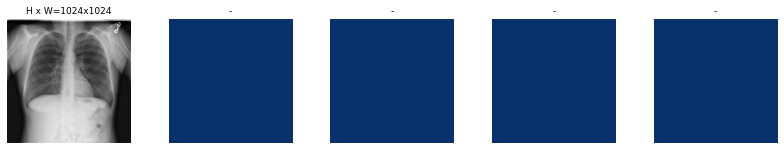

Patient Id: 7e3562b1-6f8e-4182-94da-e8df9d6e9282


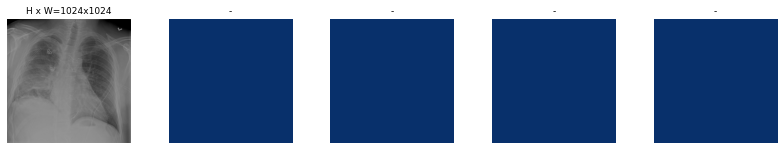

Patient Id: c7ccf0d3-c18a-4b89-acdd-9a106d6d882f


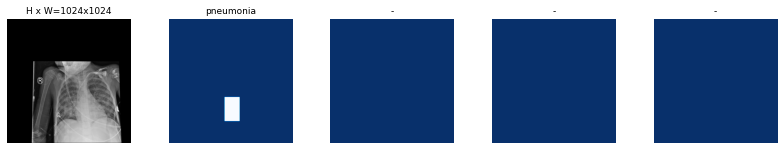

Patient Id: 1a7606e0-4d81-4bbe-ae22-93ca30540cb9


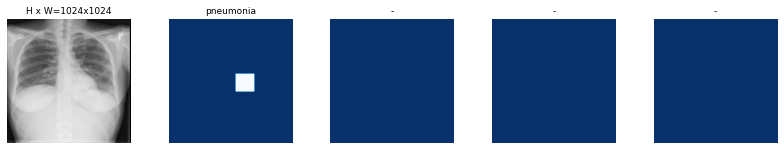

In [9]:
# Random seed
random.seed(datetime.now())

# Load and display random samples
image_ids = np.random.choice(dataset_test.image_ids, 4)
for image_id in image_ids:
    image = dataset_test.load_image(image_id)
    mask, class_ids = dataset_test.load_mask(image_id)
    info = dataset_test.image_info_alt(image_id)
    print("Patient Id:", info['id'])
    visualize.display_top_masks(image, mask, class_ids, dataset_test.class_names)

## Data augmentation (Testing purpose)

Before


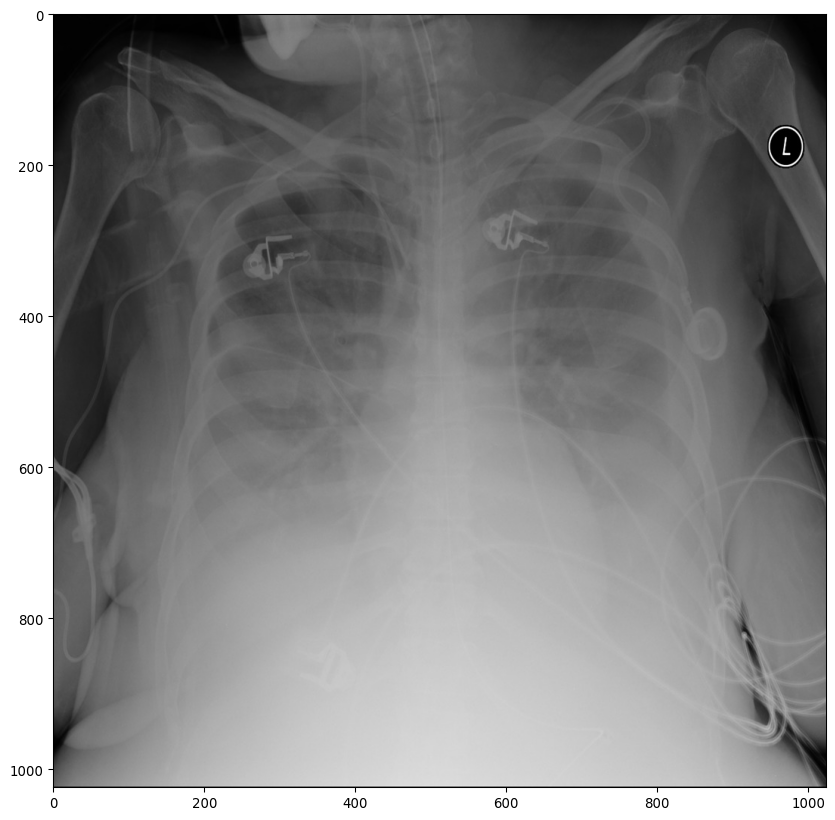

After


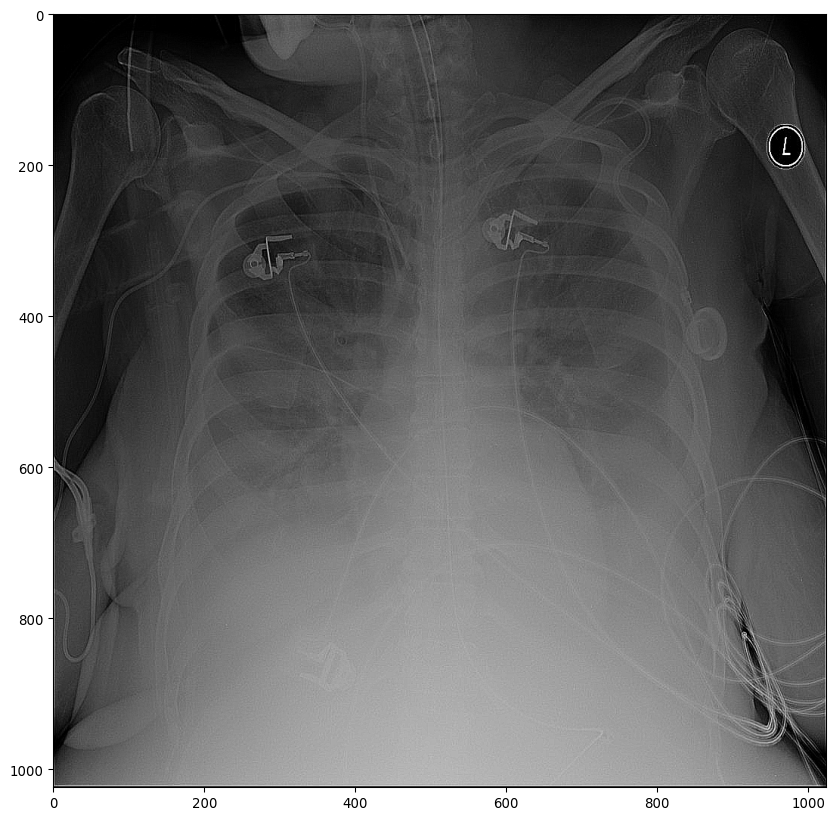

Patient Id: 81638698-2938-4b4c-8c47-729da3b5c37b
Patient Id: 77e3cf70-b78a-42fe-bd17-0ed96618d6b4
Patient Id: e5b113ec-b1fc-491e-9499-f20e825fcaa8
Patient Id: 748c1ee3-c648-440e-b1b6-be1f5440a093


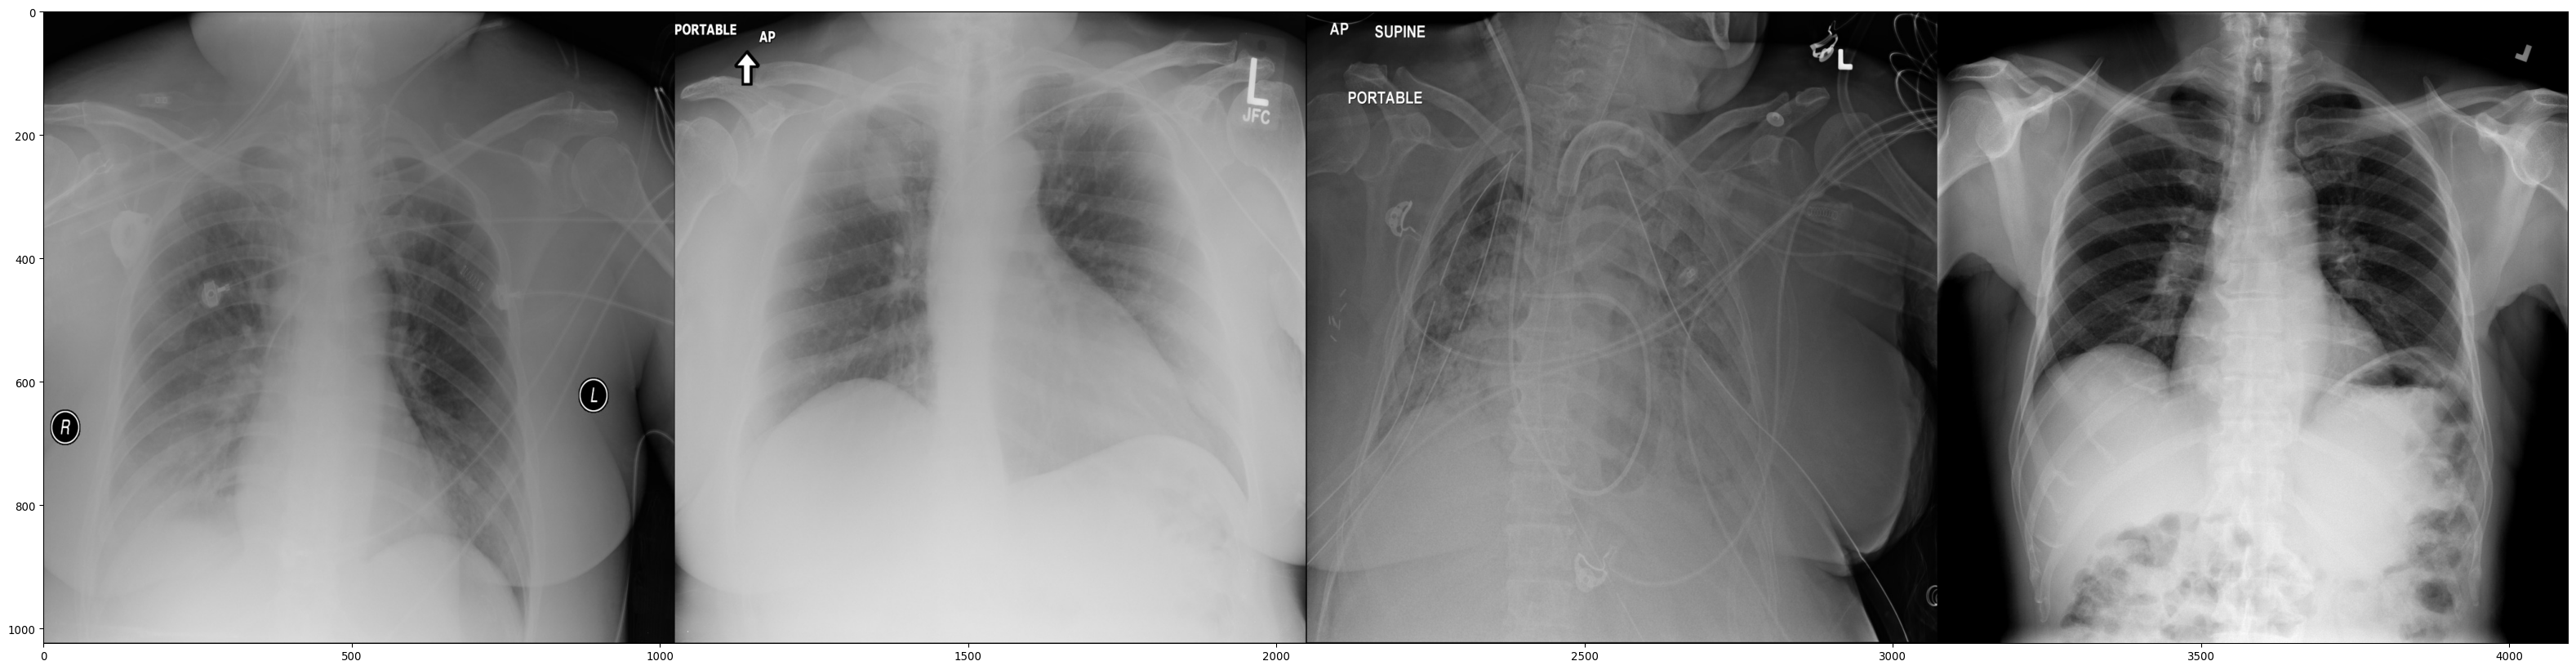

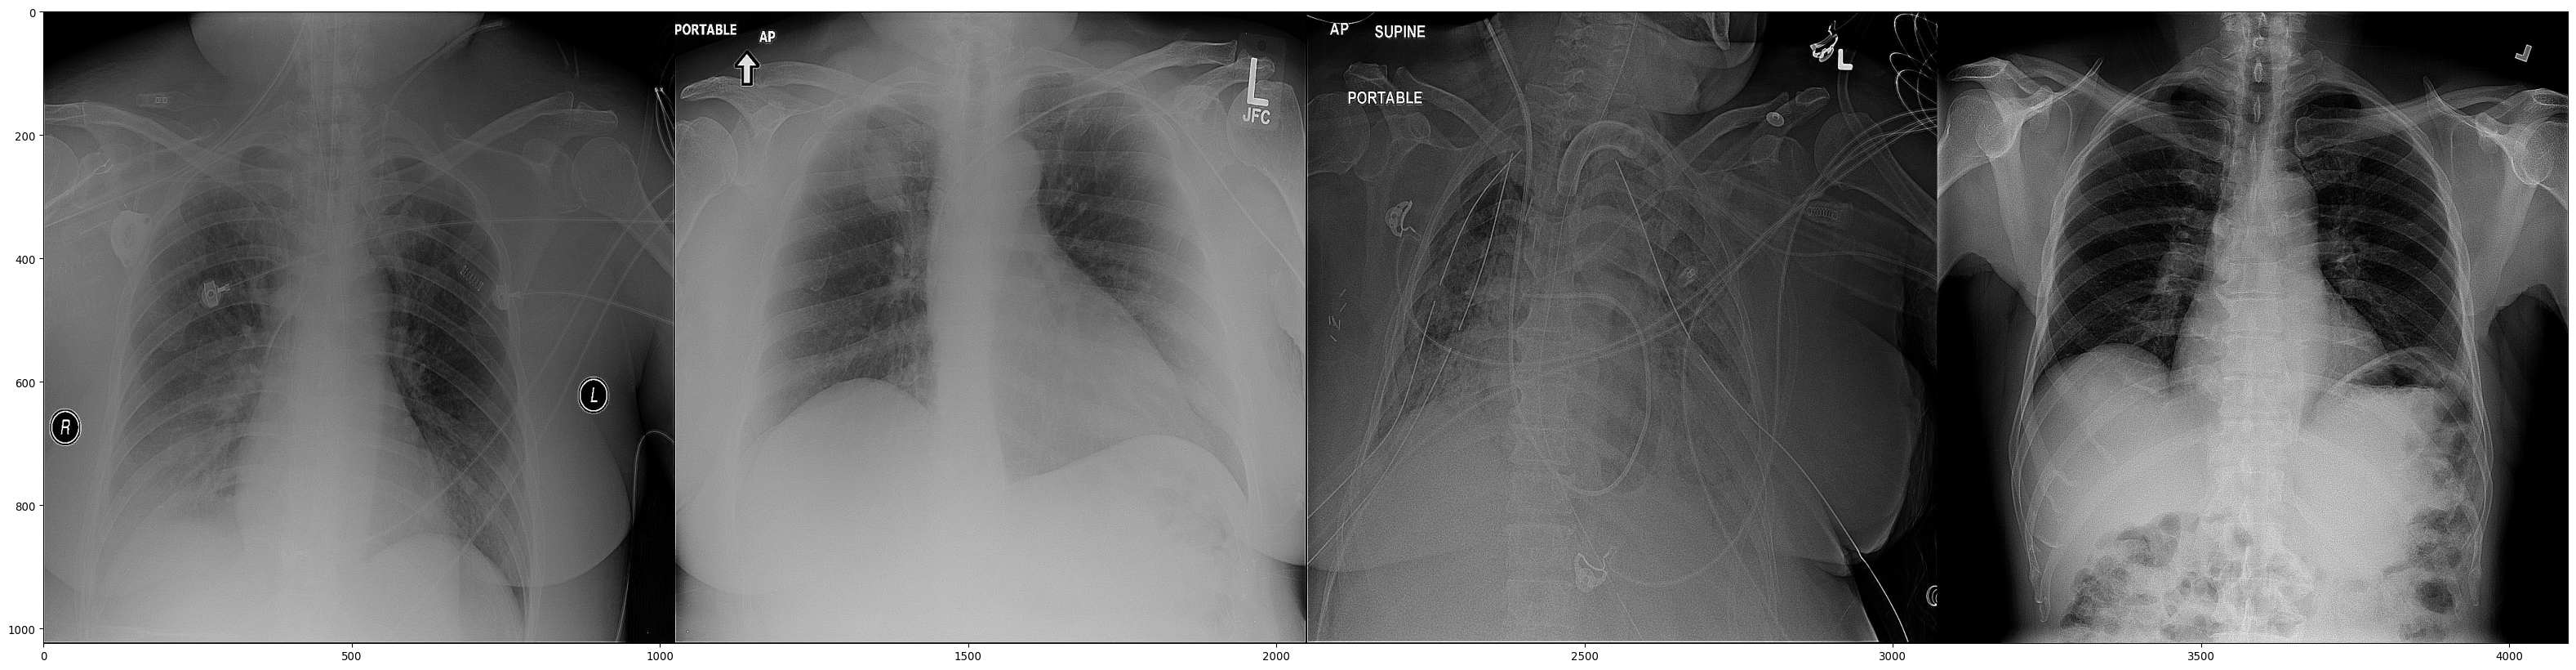

In [10]:
# Random seed
random.seed(datetime.now())

# 33ab4fe9-ce46-41c0-9074-c7ef83765af7

# Uncomment to augment on a specific patientId
patientId = "96f4aeed-716c-4db1-9f81-a186c991855e"

IMAGE_DIR = os.path.join(ROOT_DIR, "datasets/rsna/stage_2_train_images")
medical_image = dicom.dcmread(os.path.join(IMAGE_DIR, patientId + ".dcm"))
# IMAGE_DIR = os.path.join(ROOT_DIR, "datasets/rsna/stage_2_test_images")
# file_names = next(os.walk(IMAGE_DIR))[2]
# medical_image = dicom.dcmread(os.path.join(IMAGE_DIR, random.choice(file_names)))
image = medical_image.pixel_array

# Handle the case of IndexError
# If grayscale. Convert to RGB for consistency.
if image.ndim != 3:
    image = skimage.color.gray2rgb(image)
# If has an alpha channel, remove it for consistency
if image.shape[-1] == 4:
    image = image[..., :3]

print("Before")
ia.imshow(image)

# image = imageio.imread(image_path)

bbs = BoundingBoxesOnImage([
    BoundingBox(x1=66, y1=160, x2=439, y2=768),
    BoundingBox(x1=552, y1=164, x2=928, y2=840)
], shape=image.shape)

# Image Augmentation
# GaussianBlur
# Sharpen
# Change brightness
# Change contrast
seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=0.3, name="reduce-noise"),
    iaa.Sharpen(alpha=0.75, lightness=0.70, name="crispier-xrays"),
    iaa.Multiply(1.15, name="bright-xrays"),
    iaa.GammaContrast(1.2, name="gamma-xrays")
], name="chest-xrays-aug")

# Augment a Single Image
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

print("After")
ia.imshow(image_aug)

# image_bbs_draw = bbs.draw_on_image(image_aug, size=1, color=[0, 0, 255])

# ia.imshow(image_bbs_draw)

bb_gt1 = BoundingBox(x1=208, y1=303, x2=208+266, y2=303+425)
bb_gt2 = BoundingBox(x1=553, y1=147, x2=553+304, y2=147+538)
bb_gt = [bb_gt1, bb_gt2]

bb_pred1 = BoundingBox(x1=220, y1=612, x2=378, y2=715)
bb_pred2 = BoundingBox(x1=551, y1=122, x2=843, y2=573)
bb_pred3 = BoundingBox(x1=574, y1=479, x2=853, y2=763)
bb_pred4 = BoundingBox(x1=209, y1=174, x2=472 ,y2=689)
bb_pred = [bb_pred1, bb_pred2, bb_pred3, bb_pred4]

# Augment a Batch of Images
images = []

# Load and display random samples (with augmentation)
image_ids = np.random.choice(dataset_test.image_ids, 4)
for image_id in image_ids:
    info = dataset_test.image_info_alt(image_id)
    print("Patient Id:", info['id'])
    img = dataset_test.load_image(image_id)
    images.append(img)

images_aug = seq(images=images)

ia.imshow(np.hstack(images))
ia.imshow(np.hstack(images_aug))

In [11]:
def visualize_iou(gt, pred, image):
    image_bbs = np.copy(image)
    bb_inters = gt.intersection(pred)
    if bb_inters == None:
        iou = 0
    else:
        bb_inters = bb_inters.extend(all_sides=-1)
        # Intersection: red
        image_bbs = bb_inters.draw_on_image(image_bbs, size=4, color=[255, 0, 0])
        iou = gt.iou(pred)
    # Draw bounding boxes, intersection, union and IoU value on image.
    # Ground truth: cherry blossom
    image_bbs = gt.extend(all_sides=-4).draw_on_image(image_bbs, size=4, color=[255,183,197])
    # Prediction: green
    image_bbs = pred.extend(all_sides=-4).draw_on_image(image_bbs, size=4, color=[0, 255, 0])
    bb_union = gt.union(pred).extend(all_sides=2)
    # Union: blue
    image_bbs = bb_union.draw_on_image(image_bbs, size=4, color=[0, 0, 255])
    image_bbs = ia.draw_text(
        image_bbs, text="IoU=%.2f" % (iou),
        x=bb_union.x2+10, y=bb_union.y1+bb_union.height//2,
        color=[255, 255, 255], size=35
    )
    ia.imshow(image_bbs)

print("Executed")

Executed


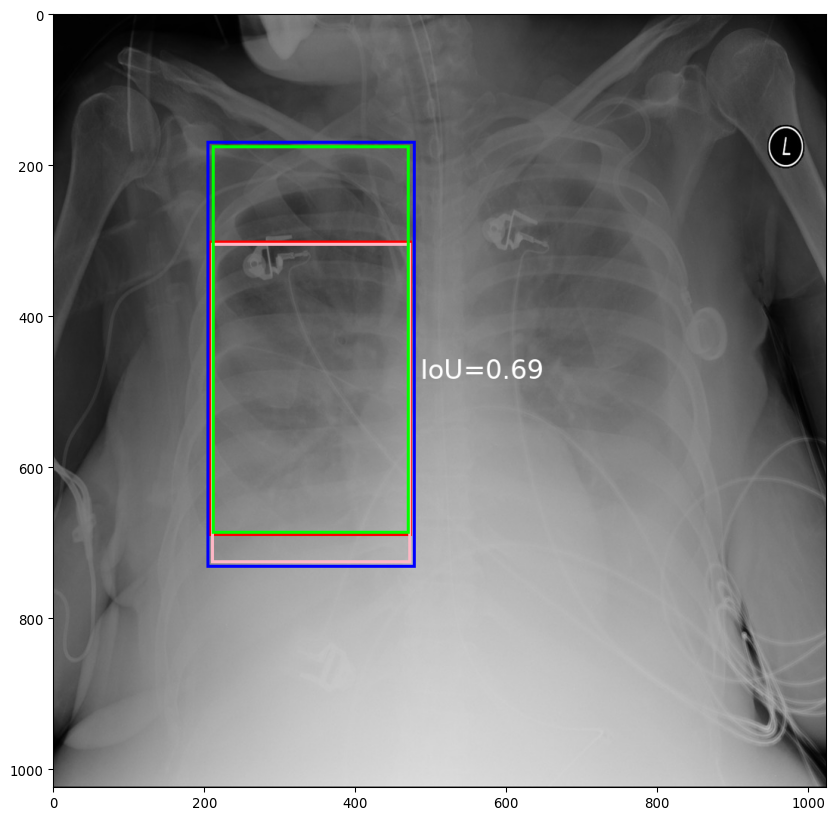

In [12]:
visualize_iou(bb_gt1, bb_pred4, image)

In [13]:
print("Medical image:", medical_image)

Medical image: Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.12913.1517874368.284966
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.12913.1517874368.284966
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) S

## Unused resources

In [ ]:
# img = mpimg.imread(img_dir)
# img = np.array(Image.open(img_dir), dtype=np.uint8)
# img = dicom.dcmread(img_dir)

# Create figure and axes
# fig,ax = plt.subplots(1)

# Display the image
# ax.imshow(image)

# Create a Rectangle patch
# rect = patches.Rectangle((550,350),140,250,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
# ax.add_patch(rect)

# imgplot = plt.imshow(image)
# plt.show()

# iaa.Cartoon(blur_ksize=3, segmentation_size=1.0, saturation=2.0, edge_prevalence=1.0),
# iaa.imgcorruptlike.GaussianNoise(severity=5),
# iaa.imgcorruptlike.Spatter(severity=5),
# iaa.Affine(scale={"x": (1), "y": (1.2)})
# iaa.Rot90(3)

## Create Model

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

print("Executed")

In [11]:
# Which weights to start with?
init_with = "rsna"  # imagenet, coco, rsna, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "rsna":
    # Load weights trained on RSNA
    model.load_weights(RSNA_WEIGHTS_PATH, by_name=True)    
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)
    
print("Executed")

Re-starting from epoch 143
Executed


In [24]:
# This function keeps the learning rate at 0.0001 for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch):
  if epoch < 10:
    return 0.0001
  else:
    return 0.0001 * math.pow(math.e, 0.1 * (10 - epoch)

# Custom callbacks
custom_callbacks = [
  keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto',
        cooldown=0, min_lr=0
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0.25, patience=5, verbose=1, mode='auto'
    ),
    keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
]

print("Executed")

Executed


In [ ]:
# Image Augmentation
# GaussianBlur
# Sharpen
# Change brightness
# Change contrast
seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=0.3, name="reduce-noise"),
    iaa.Sharpen(alpha=0.75, lightness=0.70, name="crispier-xrays"),
    iaa.Multiply(1.15, name="bright-xrays"),
    iaa.GammaContrast(1.2, name="gamma-xrays")
], name="chest-xrays-aug")

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. Simply pass `layers="all` to train all layers.

In [ ]:
# *** This training schedule is an example. Update to your needs ***
    
# Training - Stage 1
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
# print("Training head layers...")
print("Training network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=100,
            layers='heads', custom_callbacks=custom_callbacks)

# Training - Stage 2
# Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=120,
            layers='4+', custom_callbacks=custom_callbacks)

# Training - Stage 3
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=130,
            layers='all', custom_callbacks=custom_callbacks)

# Have a nice day!
print("Have a nice day!")

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_rsna.h5")
model.keras_model.save_weights(model_path)

In [ ]:
## Detection

In [14]:
class InferenceConfig(RsnaConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.98

inference_config = InferenceConfig()
inference_config.display()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = RSNA_WEIGHTS_PATH
# model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /storage/phongvt/GitHub/Mask_RCNN/logs/mask_rcnn_rsna.h5


Patient Id: ab940f3f-3e24-4923-9907-17b3507157be
Image Id: 1268
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  250.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1268.00000  int64
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:  155.00000  max:  788.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  bool


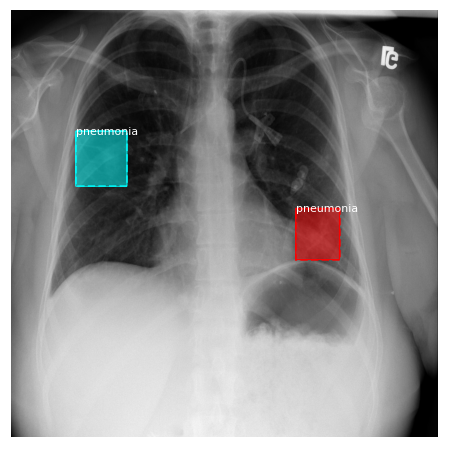

In [21]:
# Random seed
random.seed(datetime.now())

# Test on a random image
image_id = random.choice(dataset_test.image_ids)
# image_id = random.randint(3200, 4003)
info = dataset_test.image_info_alt(image_id)
print("Patient Id:", info['id'])
print("Image Id:", image_id)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_test.class_names, figsize=(8, 8), ax=get_ax())

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  250.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
ROIs: []

*** No instances to display *** 



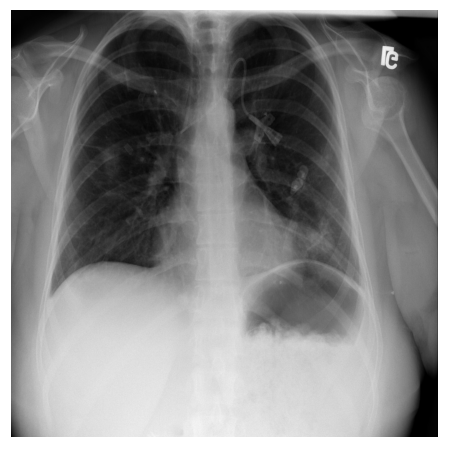

In [22]:
results = model.detect([original_image], verbose=1)

r = results[0]
print("ROIs:", r['rois'])
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())

## Evaluation

In [113]:
class InferenceConfig(RsnaConfig):
    GPU_COUNT = 3
    IMAGES_PER_GPU = 2

inference_config = InferenceConfig()
inference_config.display()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = RSNA_WEIGHTS_PATH
# model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /storage/phongvt/GitHub/Mask_RCNN/logs/mask_rcnn_rsna.h5


In [114]:
# 0 - 3100: Target == 0
# 3101 - 4002: Target == 1

def prepare_eval(dataset_test):
    """
    Prepare the test set for evaluation.
    
    Returns:
    molded_images: A list of images to feed to the model
    gt_bboxes: A list of ground-truth bounding boxes
    """
    molded_images = []
    gt_bboxes = []
    image_ids = dataset_test.image_ids

    # Load all images and ground-truth bboxes
    for image_id in image_ids:
        image, _, _, gt_bbox, _ =\
        modellib.load_image_gt(dataset_test, inference_config, 
                               image_id, use_mini_mask=False)
        molded_images.append(image)
        gt_bboxes.append(gt_bbox)
    return molded_images, gt_bboxes
    
molded_images, gt_bboxes = prepare_eval(dataset_test)

print("Executed")

Executed


In [119]:
def test_set_detection(molded_images):
    """
    Detection on the test set.
    
    Returns:
    r: A list of predicted results of each detection.
    """
    r = []
    # Run detection on each batch. 
    # A batch of type list containing six images.
    for i in range(0, len(molded_images), 6):
        # Sanity check
        # Run detection on the same image to fit the batch size.
        # Workaround
        if i == len(molded_images)-2:
            first, second = molded_images[i], molded_images[i+1]
            image_batch = [first, second, first, first, first, first]
            results = model.detect(image_batch, verbose=1)
            results = results[0:2]
            r.append(results)
        else:
            image_batch = molded_images[i:i+6]
            results = model.detect(molded_images[i:i+6], verbose=0)
            r.append(results)
    return r 
    
r = test_set_detection(molded_images)
  
print("Executed")

Processing 6 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (6, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (6, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (6, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Executed


In [121]:
def compute_iou(bb1, bb2):
    """
    Compute the IoU value of two bounding boxes.
    
    Returns:
    iou: The IoU value
    mis_match_gt: A list of mismatch ground truth
    """
    mis_match_gt = []
    y1, x1, y2, x2 = bb1
    bb_gt = BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2)
    y1, x1, y2, x2 = bb2
    bb_pred = BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2)

    # Compute intersection, union and IoU value
    # Intersection and union are both bounding boxes. They are here
    # decreased/increased in size purely for better visualization.
    bb_inters = bb_gt.intersection(bb_pred)

    # Handle the case of no intersection
    if bb_inters == None:
        mis_match_gt.append(bb1.tolist())
        return None, mis_match_gt

    bb_inters = bb_gt.intersection(bb_pred).extend(all_sides=-1)
    bb_union = bb_gt.union(bb_pred).extend(all_sides=2)
    iou = bb_gt.iou(bb_pred)
    return iou, mis_match_gt

print("Executed")

Executed


In [122]:
def compute_matches(gt_result, pred_result):
    """
    Compute the IoU and classify them @IoU=0.5
    
    Returns:
    TP: True positive cases
    FP: False positive cases
    TN: True negative cases
    FN: False negative cases
    IoU: A list of IoU values.
    """
    TP, FP, TN, FN = 0, 0, 0, 0
    IoU = []
    # Loop through each batch (six images per batch)
    for i in range(len(pred_result)):
        gt = gt_result[i]
        pr = pred_result[i]
        roi = pr['rois']
        
        # Matched gt
        matched_gt = []
        # Mismatch gt
        mis_match_gt = []
        
        # Handle the case of no ground-truth in an image
        # but the model detects ROI anyway => FP
        if len(gt) == 0 and len(roi) != 0:
            IoU.append(0)
            FP += 1
            continue
                
        # Handle the case of no ground-truth in an image
        # and no ROI => TN
        if len(gt) == 0 and len(roi) == 0:
            TN += 1
            print("Will this show up?")
            continue

        # Iterate through each predicted bb 
        # over ground-truth bb
        for roi in pr['rois']:    
            for gt_bbox in gt:
                iou, mm_gt = compute_iou(gt_bbox, roi)
                # Join list
                mis_match_gt += mm_gt
                if iou == None:
                    continue
                if (iou >= 0.5):
                    IoU.append(iou)
                    matched_gt.append(gt_bbox.tolist())
                    TP += 1
                else:
                    IoU.append(iou)
                    matched_gt.append(gt_bbox.tolist())
                    FP += 1

        # When a ground truth is present in the image and model failed to detect the object, 
        # classify it as False Negative(FN).
        for gt_bbox in mis_match_gt:
            if gt_bbox not in matched_gt:
                FN += 1
                
    return [TP, FP, TN, FN], IoU

print("Executed")

Executed


In [123]:
def evaluate_rsna(gt_results, pred_results):
    """
    Evaluate the model trained with the RSNA dataset.
    
    Returns:
    precision
    recall
    confusion_matrix
    IoU: A list containing IoU values to compute the mean (average)
    """
    TP, FP, TN, FN = 0, 0, 0, 0
    IoU = []
    for i in range(0, len(gt_results), 6):
        pred_result = pred_results[i//6]
        gt_result = gt_results[i:i+6]
        confusion_matrix, iou = compute_matches(gt_result, pred_result)
        TP += confusion_matrix[0]
        FP += confusion_matrix[1]
        TN += confusion_matrix[2]
        FN += confusion_matrix[3]
        IoU += iou
    
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    confusion_matrix = [TP, FP, TN, FN]
    return precision, recall, confusion_matrix , IoU   

print("Executed")

Executed


In [124]:
precision, recall, confusion_matrix, IoU = evaluate_rsna(gt_bboxes, r)

TP, FP, TN, FN = confusion_matrix

print("Executed")

Will this show up?
Will this show up?
Will this show up?
Will this show up?
Will this show up?
Will this show up?
Executed


In [125]:
print(len(gt_bboxes))
print(len(r))
print(len(molded_images))
print(len(IoU))

1802
301
1802
2646


In [126]:
print("True positive:", TP)
print("False positive:", FP)
print("True negative:", TN)
print("False negative:", FN)

True positive: 1210
False positive: 1436
True negative: 6
False negative: 7


In [127]:
accuracy = (TP+TN)/(TP+TN+FP+FN)
print("IoU:", round(mean(IoU),2))
print("Accuracy: %.2f" % accuracy)
print("Precision: %.2f" % precision)
print("Recall: %.2f" % recall)

IoU: 0.38
Accuracy: 0.46
Precision: 0.46
Recall: 0.99


## We live in a twilight world

In [59]:
# Random seed
random.seed(datetime.now())

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
# image_ids = np.random.choice(dataset_test.image_ids, 10)
image_ids = random.sample(range(900, 1803), 5)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config,
                               image_id, use_mini_mask=False)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)

In [ ]:
print("mAP: ", np.mean(APs))
print("Precision:", len(precisions_alt))
print("Recall:", len(recalls_alt))

In [35]:
precs = []
recs = []
for pr in precisions_alt:
    for item in pr:
        precs.append(item)

for re in recalls_alt:
    for item in re:
        recs.append(item)

In [ ]:
print(len(precs))
print(len(recs))
print(precisions)
print(recalls)

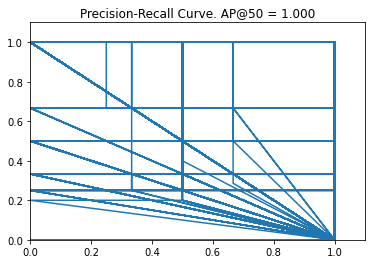

In [62]:
visualize.plot_precision_recall(AP, precs, recs)